# Homework 2

##### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import mahalanobis
from scipy.optimize import minimize

##### Class Definitions (used for problems)

In [2]:
class Person:

    def __init__(self):
        self.g1 = None
        self.g2 = None
        self.e1 = None
        self.e2 = None
        self.p1 = None
        self.p2 = None
    
    def __repr__(self):
        try:
            return f'Person, g: {str(round(self.g1, 3)), str(round(self.g2, 3))}, e: {str(round(self.e1, 3)), str(round(self.e2, 3))}'
        except:
            return 'Person Object'

    #### Problem 1a
    def simulate_two_traits(self, h2_1, h2_2, rg, re):
        # simulate genetic components
        mean = [0, 0]
        cov = [[h2_1, rg*np.sqrt(h2_1)*np.sqrt(h2_2)], 
               [rg*np.sqrt(h2_1)*np.sqrt(h2_2), h2_2]]
        self.g1, self.g2 = np.random.multivariate_normal(mean, cov)

        # simulate environmental components
        mean = [0, 0]
        cov = [[1-h2_1, re*np.sqrt((1-h2_1)*(1-h2_2))], 
                [re*np.sqrt((1-h2_1)*(1-h2_2)), 1-h2_2]]
        self.e1, self.e2 = np.random.multivariate_normal(mean, cov)

        # simulate phenotypes
        self.p1 = self.g1 + self.e1
        self.p2 = self.g2 + self.e2

    #### Problem 1b
    def get_traits_from_parents(self, parent_gen, h2_1, h2_2, rg, re, par1 = None, par2 = None):
        # choose two random parents
        if par1 is None and par2 is None:
            self.par1, self.par2 = np.random.choice(parent_gen.people, size=2, replace=False)
        else:
            self.par1 = par1
            self.par2 = par2
        
        # joint transmission of genetic components
        assert self.g1 is None and self.g2 is None and self.e1 is None and self.e2 is None # sanity check
        mean = [np.mean([self.par1.g1, self.par2.g1]), np.mean([self.par1.g2, self.par2.g2])] # midparent values
        va_matrix = [[h2_1, rg*np.sqrt(h2_1)*np.sqrt(h2_2)], 
               [rg*np.sqrt(h2_1)*np.sqrt(h2_2), h2_2]]
        cov = 0.5*np.array(va_matrix)
        self.g1, self.g2 = np.random.multivariate_normal(mean, cov)

        # simulate environmental components
        mean = [0, 0]
        cov = [[1-h2_1, re*np.sqrt((1-h2_1)*(1-h2_2))], 
                [re*np.sqrt((1-h2_1)*(1-h2_2)), 1-h2_2]]
        self.e1, self.e2 = np.random.multivariate_normal(mean, cov)

        # simulate phenotypes
        self.p1 = self.g1 + self.e1
        self.p2 = self.g2 + self.e2






In [3]:
class Generation:

    def __init__(self):
        self.people = []

    def add_person(self, person):
        self.people.append(person)
    
    #### Problem 2
    def plot_midparent_offspring_regression(self, trait_tuple, h2_1, h2_2, rg, re):
        assert len(trait_tuple) == 4

        # define plot
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('Midparent vs Offspring Phenotypes')
        axis_map = {trait_tuple[0]: (0, 0), trait_tuple[1]: (0, 1), trait_tuple[2]: (1, 0), trait_tuple[3]: (1, 1)}

        for offspring_trait, parent_trait in trait_tuple:
            assert offspring_trait == 1 or offspring_trait == 2
            assert parent_trait == 1 or parent_trait == 2

            offspring_phen = []
            midparent_phen = []
            for offspring in self.people:
                midparent_p1 = np.mean([offspring.par1.p1, offspring.par2.p1])
                midparent_p2 = np.mean([offspring.par1.p2, offspring.par2.p2])

                # obtain and plot midparent phenotype vs offspring phenotype
                if offspring_trait == 1:
                    offspring_phen.append(offspring.p1)
                elif offspring_trait == 2:
                    offspring_phen.append(offspring.p2)
                if parent_trait == 1:
                    midparent_phen.append(midparent_p1)
                elif parent_trait == 2:
                    midparent_phen.append(midparent_p2)
                
            axes[axis_map[(offspring_trait, parent_trait)]].scatter(midparent_phen, offspring_phen, s=8)
            axes[axis_map[(offspring_trait, parent_trait)]].set_xlabel('Midparent Phenotype')
            axes[axis_map[(offspring_trait, parent_trait)]].set_ylabel('Offspring Phenotype')
            axes[axis_map[(offspring_trait, parent_trait)]].set_title(f'MP Trait {parent_trait} vs O Trait {offspring_trait}')
        
            # expected regression line
            if offspring_trait == 1 and parent_trait == 1:
                exp_slope = h2_1
            elif offspring_trait == 2 and parent_trait == 2:
                exp_slope = h2_2
            else:
                exp_slope = rg * np.sqrt(h2_1) * np.sqrt(h2_2)

            exp_offspring_phen = np.array(midparent_phen) * exp_slope
            axes[axis_map[(offspring_trait, parent_trait)]].plot(midparent_phen, exp_offspring_phen, c = 'red', label = 'Expected Offspring Phenotype')

            # plot best fit line
            coefficients = np.polyfit(midparent_phen, offspring_phen, 1)
            slope = coefficients[0]
            intercept = coefficients[1]
            best_fit = slope * np.array(midparent_phen) + intercept
            axes[axis_map[(offspring_trait, parent_trait)]].plot(midparent_phen, best_fit, c = 'purple', label = 'Best Fit')
            axes[axis_map[(offspring_trait, parent_trait)]].legend(loc = 'lower right')

            if offspring_trait == parent_trait:
                axes[axis_map[(offspring_trait, parent_trait)]].text(-2, 2.5, 'Heritability: ' + str(round(slope, 3)))
            else:
                rg_estimate = slope / (np.sqrt(h2_1) * np.sqrt(h2_2))
                axes[axis_map[(offspring_trait, parent_trait)]].text(-2, 2.5, 'Rg: ' + str(round(rg_estimate, 3)))
    

    # Problem 3
    def next_gen_simulator(self, n_generations, fitness_function, h2_1, h2_2, beta_1, beta_2, rg, re):

        # function to reshape fitness values from 0-1
        # Wi/n * 1/mean(W)
        def squish(x):
            mean_x = np.mean(x)
            x_normalized = (x / 1000 )*(1/mean_x)
            return x_normalized

        simulated_generations = [self]
        for i in range(n_generations - 1):
            parent_gen = simulated_generations[-1]
            child_gen = Generation()

            parent_gen.p1 = [per.p1 for per in parent_gen.people]
            parent_gen.p2 = [per.p2 for per in parent_gen.people]
            try:
                parent_gen.fitness = squish(fitness_function(parent_gen.p1, parent_gen.p2, beta_1, beta_2))
            except:
                parent_gen.fitness = squish(fitness_function(parent_gen.p1, parent_gen.p2))

            for i in range(len(parent_gen.people)):
                per = Person()
                par1, par2 = np.random.choice(parent_gen.people, p = parent_gen.fitness, size = 2)
                per.get_traits_from_parents(parent_gen, h2_1, h2_2, rg, re, par1, par2)
                child_gen.add_person(per)
            simulated_generations.append(child_gen)
        
        child_gen.p1 = [per.p1 for per in child_gen.people]
        child_gen.p2 = [per.p2 for per in child_gen.people]
        try:
            child_gen.fitness = squish(fitness_function(child_gen.p1, child_gen.p2, beta_1, beta_2))
        except:
            child_gen.fitness = squish(fitness_function(child_gen.p1, child_gen.p2))
        
        return simulated_generations
    
    # Problem 3
    def next_gen_expected_simulator(self, n_generations, h2_1, h2_2, beta_1, beta_2):
        # gives expected mean phenotype over generations according to univariate breeder's equation
        # Pt = P0 + tVaB

        va_1 = 1*h2_1
        va_2 = 1*h2_2
        p1_0 = np.mean(self.p1)
        p2_0 = np.mean(self.p2)

        exp_p1 = []
        exp_p2 = []
        for t in range(n_generations):
            exp_p1.append(p1_0 + t*va_1*beta_1)
            exp_p2.append(p2_0 + t*va_2*beta_2)
        
        print(len)
        return exp_p1, exp_p2



##### Problem 1

In [4]:
#### Problem 1a (see class Person definitions for method)

h2_1 = 0.8
h2_2 = 0.5
rg = 0.8
re = -0.5

gen1 = Generation()

for i in range(1000):
    per = Person()
    per.simulate_two_traits(h2_1, h2_2, rg, re)
    gen1.add_person(per)

Text(0.5, 1.0, 'Frequency of Phenotypes for Trait 1 in Gen 1')

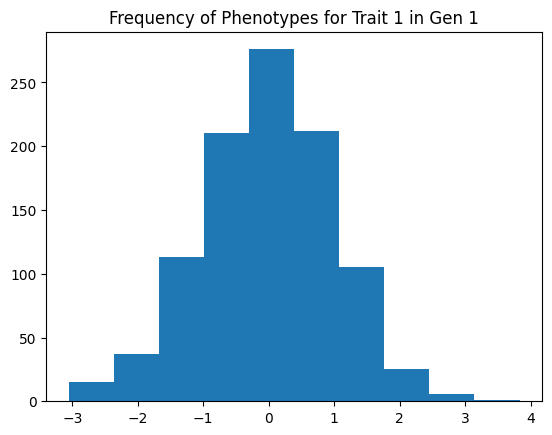

In [5]:
plt.hist([per.p1 for per in gen1.people])
plt.title('Frequency of Phenotypes for Trait 1 in Gen 1')

Text(0.5, 1.0, 'Frequency of Phenotypes for Trait 2 in Gen 1')

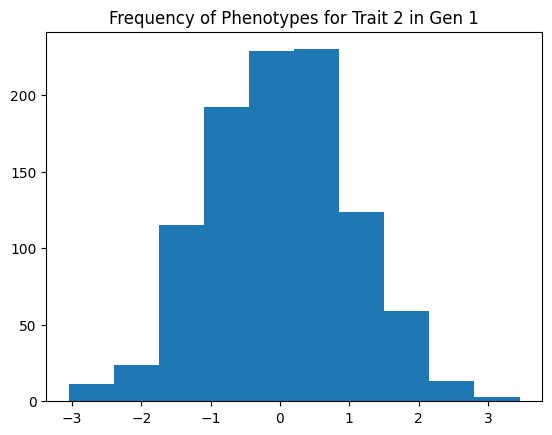

In [6]:
plt.hist([per.p2 for per in gen1.people])
plt.title('Frequency of Phenotypes for Trait 2 in Gen 1')

In [7]:
#### Problem 1b (see class Person definitions for method)

h2_1 = 0.8
h2_2 = 0.5
rg = 0.8
re = -0.5

gen2 = Generation()

for i in range(1000):
    per = Person()
    per.get_traits_from_parents(gen1, h2_1, h2_2, rg, re)
    gen2.add_person(per)

Text(0.5, 1.0, 'Frequency of Phenotypes for Trait 1 in Gen 2')

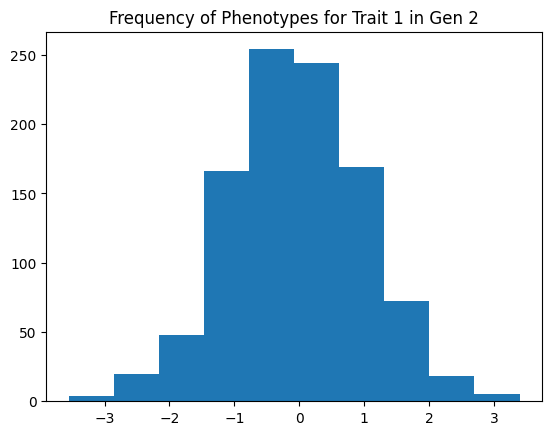

In [8]:
plt.hist([per.p1 for per in gen2.people])
plt.title('Frequency of Phenotypes for Trait 1 in Gen 2')

Text(0.5, 1.0, 'Frequency of Phenotypes for Trait 2 in Gen 2')

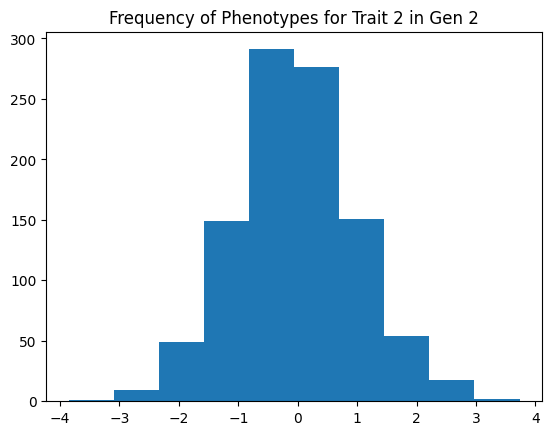

In [9]:
plt.hist([per.p2 for per in gen2.people])
plt.title('Frequency of Phenotypes for Trait 2 in Gen 2')

##### Problem 2

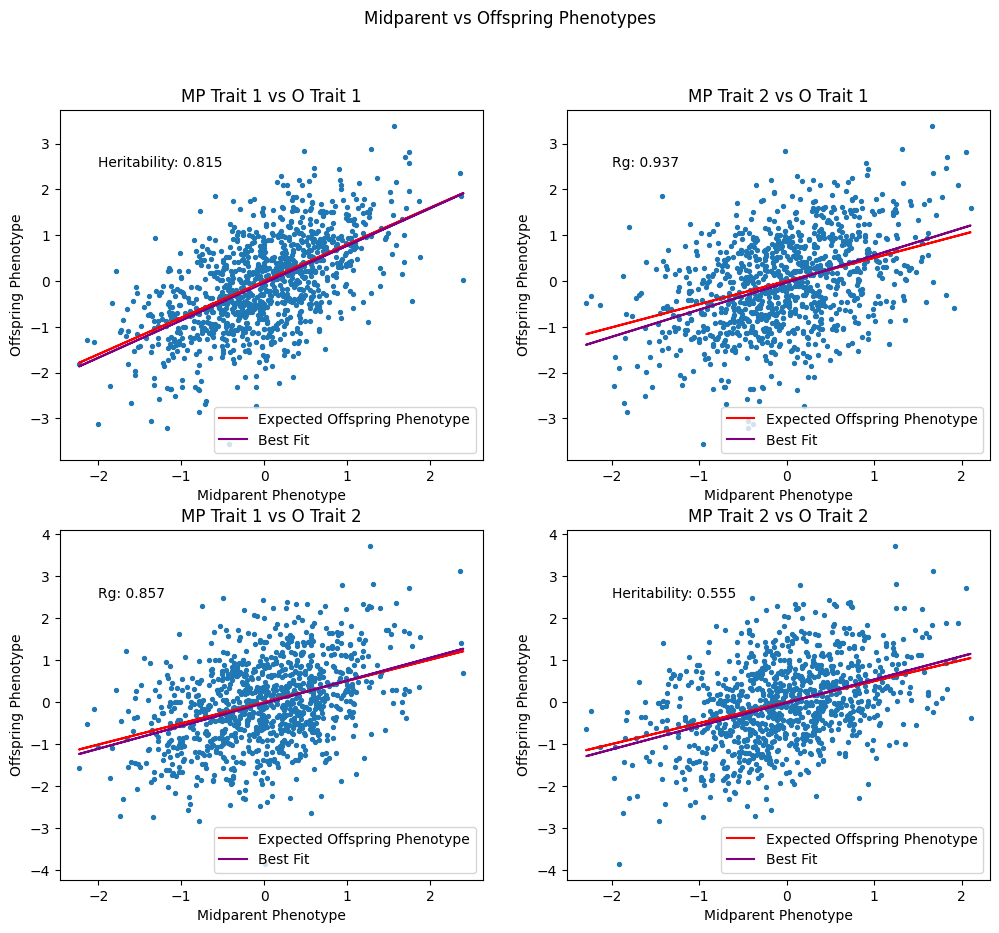

In [10]:
#### Problem 2a + 2b (see class Generation definitions for method)

trait_tuple = ((1, 1), (1, 2), (2, 1), (2, 2))
gen2.plot_midparent_offspring_regression(trait_tuple, h2_1, h2_2, rg, re)

##### Problem 3

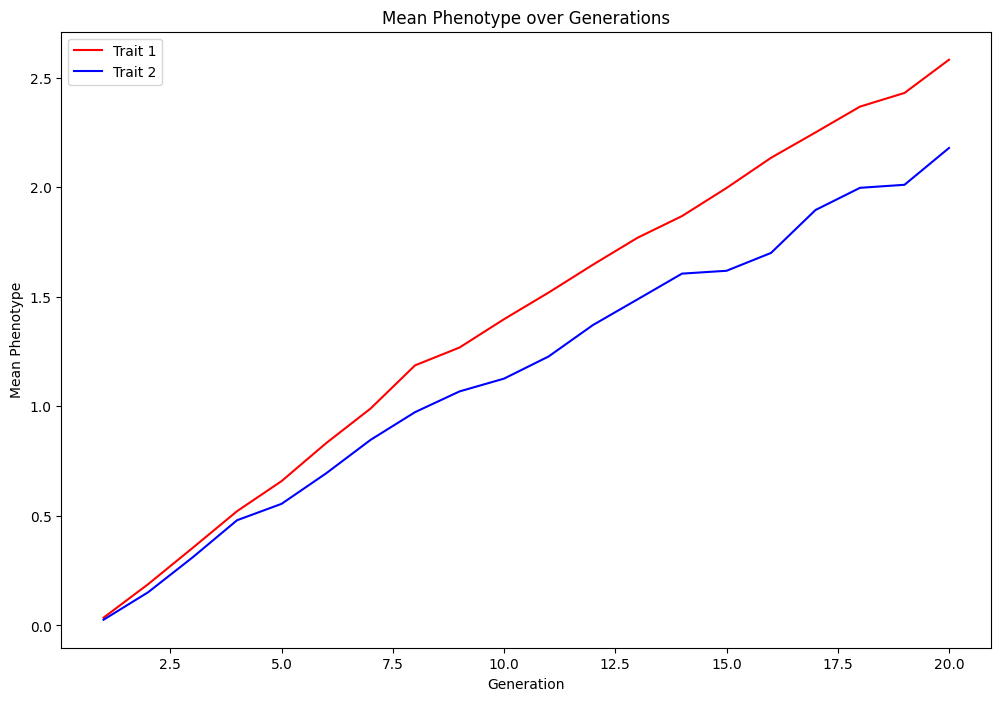

In [11]:
#### Problem 3a (example with parameters below)

h2_1 = 0.8
h2_2 = 0.5
rg = 0.8
re = -0.5
beta_1 = 0.1
beta_2 = 0.2

# w = 1 + B1p1 + B2p2
def linear_w_from_p(p1, p2, beta_1, beta_2):
    w = 1 + beta_1*np.array(p1) + beta_2*np.array(p2)
    return w

gen1 = Generation()

for i in range(1000):
    per = Person()
    per.simulate_two_traits(h2_1, h2_2, rg, re)
    gen1.add_person(per)

simulated_generations = gen1.next_gen_simulator(20, linear_w_from_p, h2_1, h2_2, beta_1, beta_2, rg, re)

generations = range(1, 21)
p1_mean = [np.mean(simulated_generations[i].p1) for i in range(20)]
p2_mean = [np.mean(simulated_generations[i].p2) for i in range(20)]

plt.figure(figsize = (12, 8))
plt.plot(generations, p1_mean, label = 'Trait 1', c = 'red')
plt.plot(generations, p2_mean, label = 'Trait 2', c = 'blue')

plt.xlabel('Generation')
plt.ylabel('Mean Phenotype')
plt.title('Mean Phenotype over Generations')
plt.legend()

<built-in function len>


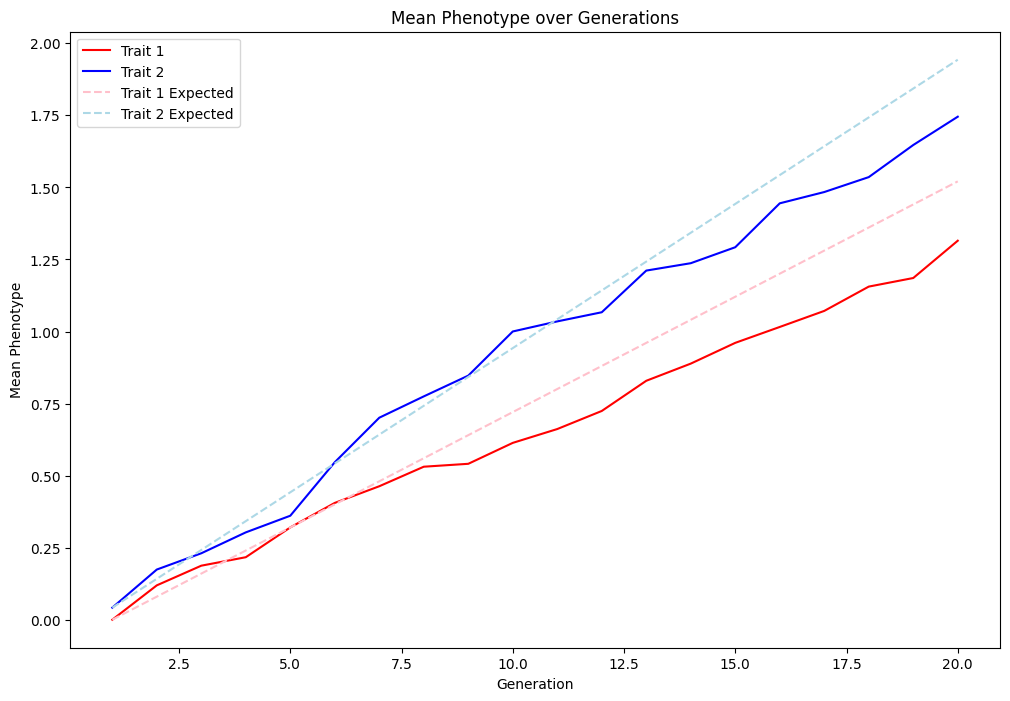

In [12]:
#### Problem 3b

h2_1 = 0.8
h2_2 = 0.5
rg = 0
re = 0
beta_1 = 0.1
beta_2 = 0.2

# w = 1 + B1p1 + B2p2
def linear_w_from_p(p1, p2, beta_1, beta_2):
    w = 1 + beta_1*np.array(p1) + beta_2*np.array(p2)
    return w

gen1 = Generation()

for i in range(1000):
    per = Person()
    per.simulate_two_traits(h2_1, h2_2, rg, re)
    gen1.add_person(per)

# see above in class Generation definitions
simulated_generations = gen1.next_gen_simulator(20, linear_w_from_p, h2_1, h2_2, beta_1, beta_2, rg, re)
exp_p1, exp_p2 = gen1.next_gen_expected_simulator(20, h2_1, h2_2, beta_1, beta_2)

generations = range(1, 21)
p1_mean = [np.mean(simulated_generations[i].p1) for i in range(20)]
p2_mean = [np.mean(simulated_generations[i].p2) for i in range(20)]

plt.figure(figsize = (12, 8))
plt.plot(generations, p1_mean, label = 'Trait 1', c = 'red')
plt.plot(generations, p2_mean, label = 'Trait 2', c = 'blue')
plt.plot(generations, exp_p1, label = 'Trait 1 Expected', linestyle = '--', c = 'pink')
plt.plot(generations, exp_p2, label = 'Trait 2 Expected', linestyle = '--', c = 'lightblue')

plt.xlabel('Generation')
plt.ylabel('Mean Phenotype')
plt.title('Mean Phenotype over Generations')
plt.legend()

<built-in function len>


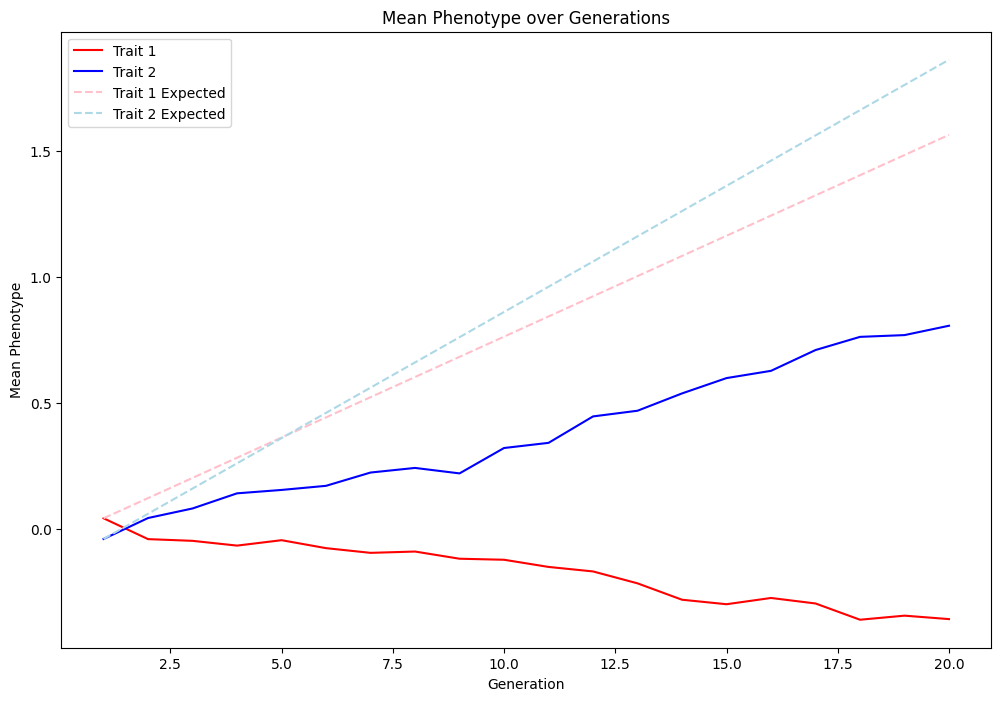

In [13]:
#### Problem 3c part 1 (one trait evolves in opposite direction)

h2_1 = 0.8
h2_2 = 0.5
rg = -0.8
re = -0.5
beta_1 = 0.1
beta_2 = 0.2

# w = 1 + B1p1 + B2p2
def linear_w_from_p(p1, p2, beta_1, beta_2):
    w = 1 + beta_1*np.array(p1) + beta_2*np.array(p2)
    return w

gen1 = Generation()

for i in range(1000):
    per = Person()
    per.simulate_two_traits(h2_1, h2_2, rg, re)
    gen1.add_person(per)

simulated_generations = gen1.next_gen_simulator(20, linear_w_from_p, h2_1, h2_2, beta_1, beta_2, rg, re)
exp_p1, exp_p2 = gen1.next_gen_expected_simulator(20, h2_1, h2_2, beta_1, beta_2)

generations = range(1, 21)
p1_mean = [np.mean(simulated_generations[i].p1) for i in range(20)]
p2_mean = [np.mean(simulated_generations[i].p2) for i in range(20)]

plt.figure(figsize = (12, 8))
plt.plot(generations, p1_mean, label = 'Trait 1', c = 'red')
plt.plot(generations, p2_mean, label = 'Trait 2', c = 'blue')
plt.plot(generations, exp_p1, label = 'Trait 1 Expected', linestyle = '--', c = 'pink')
plt.plot(generations, exp_p2, label = 'Trait 2 Expected', linestyle = '--', c = 'lightblue')

plt.xlabel('Generation')
plt.ylabel('Mean Phenotype')
plt.title('Mean Phenotype over Generations')
plt.legend()

<built-in function len>


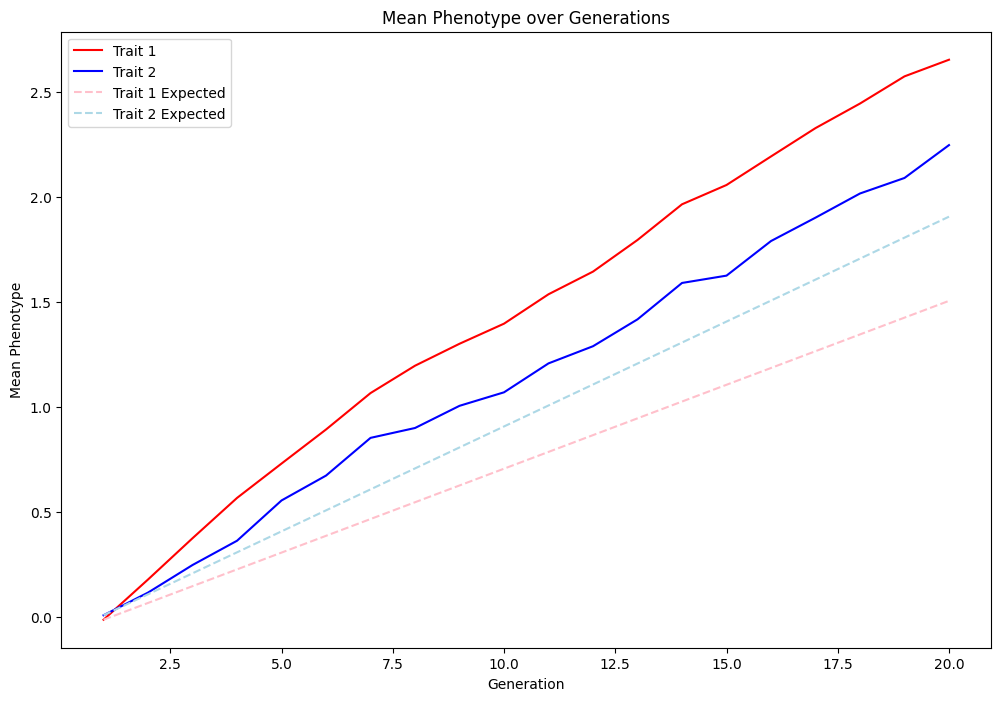

In [14]:
#### Problem 3c part 2 (same direction but faster)

h2_1 = 0.8
h2_2 = 0.5
rg = 0.9
re = -0.5
beta_1 = 0.1
beta_2 = 0.2

# w = 1 + B1p1 + B2p2
def linear_w_from_p(p1, p2, beta_1, beta_2):
    w = 1 + beta_1*np.array(p1) + beta_2*np.array(p2)
    return w

gen1 = Generation()

for i in range(1000):
    per = Person()
    per.simulate_two_traits(h2_1, h2_2, rg, re)
    gen1.add_person(per)

simulated_generations = gen1.next_gen_simulator(20, linear_w_from_p, h2_1, h2_2, beta_1, beta_2, rg, re)
exp_p1, exp_p2 = gen1.next_gen_expected_simulator(20, h2_1, h2_2, beta_1, beta_2)

generations = range(1, 21)
p1_mean = [np.mean(simulated_generations[i].p1) for i in range(20)]
p2_mean = [np.mean(simulated_generations[i].p2) for i in range(20)]

plt.figure(figsize = (12, 8))
plt.plot(generations, p1_mean, label = 'Trait 1', c = 'red')
plt.plot(generations, p2_mean, label = 'Trait 2', c = 'blue')
plt.plot(generations, exp_p1, label = 'Trait 1 Expected', linestyle = '--', c = 'pink')
plt.plot(generations, exp_p2, label = 'Trait 2 Expected', linestyle = '--', c = 'lightblue')

plt.xlabel('Generation')
plt.ylabel('Mean Phenotype')
plt.title('Mean Phenotype over Generations')
plt.legend()

##### Problem 4

In [15]:
#### Problem 4a

def gaussian_w_from_p(p1, p2):
    
    # setting the ideal phenotypes to be p1 = 1, p2 = 3
    mu = np.array([1, 3])
    cov = np.array([[10, -7], [-7, 10]])
    
    p1 = np.array(p1)
    p2 = np.array(p2)
    points = np.vstack((p1, p2)).T
    inv_cov = np.linalg.inv(cov)

    # mahalanobis comes from scipy
    w = np.array([
        np.exp(-0.5 * mahalanobis(point, mu, inv_cov)**2)
        for point in points
    ])
    return w

def fitness_to_optimize(x):
    p1 = [x[0]]
    p2 = [x[1]]
    fitness = gaussian_w_from_p(p1, p2)
    return -fitness[0]

result = minimize(fitness_to_optimize, [1, 1])
result # when p1, p2 = mu, fitness is maximized

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.9999999999996201
        x: [ 1.000e+00  3.000e+00]
      nit: 12
      jac: [ 2.980e-07  3.800e-07]
 hess_inv: [[ 9.998e+00 -7.018e+00]
            [-7.018e+00  9.855e+00]]
     nfev: 39
     njev: 13

<built-in function len>


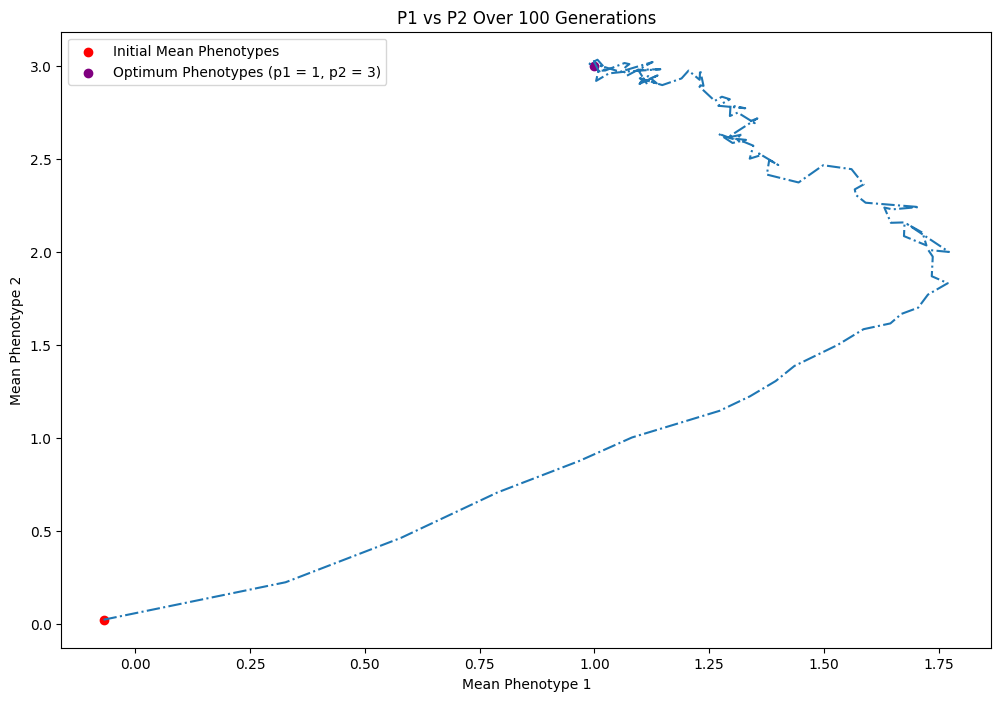

In [16]:
#### Problem 4b

h2_1 = 0.8
h2_2 = 0.5
rg = 0
re = 0

gen1 = Generation()

for i in range(1000):
    per = Person()
    per.simulate_two_traits(h2_1, h2_2, rg, re)
    gen1.add_person(per)

simulated_generations = gen1.next_gen_simulator(100, gaussian_w_from_p, h2_1, h2_2, beta_1, beta_2, rg, re)
exp_p1, exp_p2 = gen1.next_gen_expected_simulator(100, h2_1, h2_2, beta_1, beta_2)

p1_mean = [np.mean(simulated_generations[i].p1) for i in range(100)]
p2_mean = [np.mean(simulated_generations[i].p2) for i in range(100)]

plt.figure(figsize = (12, 8))
plt.plot(p1_mean, p2_mean, linestyle = 'dashdot')
plt.xlabel('Mean Phenotype 1')
plt.ylabel('Mean Phenotype 2')
plt.title('P1 vs P2 Over 100 Generations')
plt.scatter(p1_mean[0], p2_mean[0], c = 'red', label = 'Initial Mean Phenotypes')
plt.scatter(1, 3, c = 'purple', label = 'Optimum Phenotypes (p1 = 1, p2 = 3)')
plt.legend()

<built-in function len>


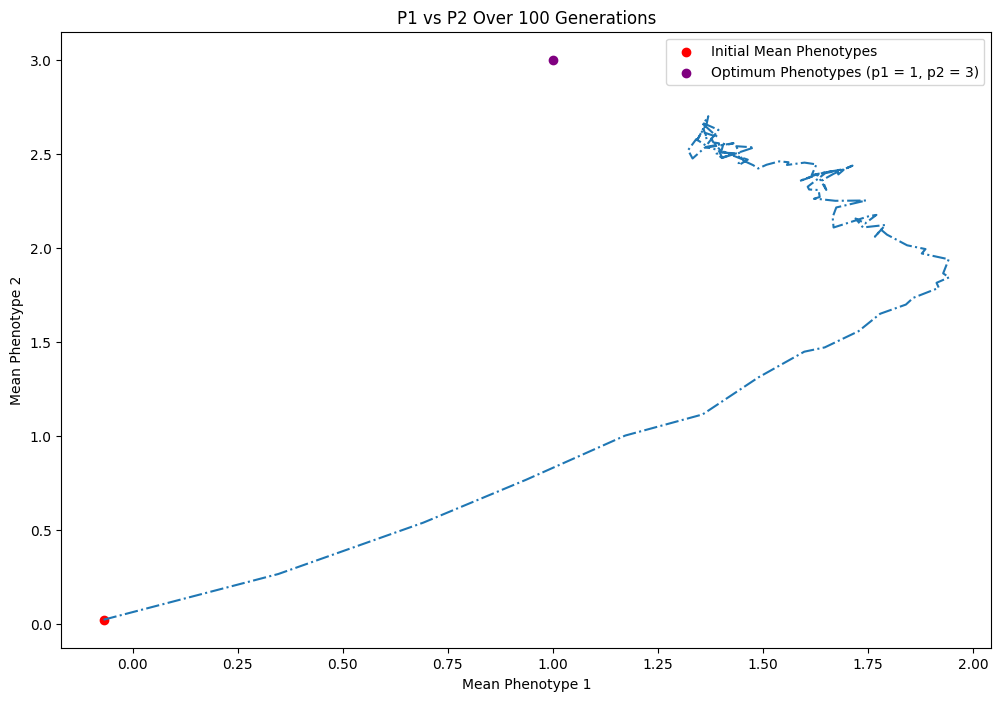

In [17]:
#### Problem 4c

h2_1 = 0.8
h2_2 = 0.5
rg = 0.5
re = 0

simulated_generations = gen1.next_gen_simulator(100, gaussian_w_from_p, h2_1, h2_2, beta_1, beta_2, rg, re)
exp_p1, exp_p2 = gen1.next_gen_expected_simulator(100, h2_1, h2_2, beta_1, beta_2)

p1_mean = [np.mean(simulated_generations[i].p1) for i in range(100)]
p2_mean = [np.mean(simulated_generations[i].p2) for i in range(100)]

plt.figure(figsize = (12, 8))
plt.plot(p1_mean, p2_mean, linestyle = 'dashdot')
plt.xlabel('Mean Phenotype 1')
plt.ylabel('Mean Phenotype 2')
plt.title('P1 vs P2 Over 100 Generations')
plt.scatter(p1_mean[0], p2_mean[0], c = 'red', label = 'Initial Mean Phenotypes')
plt.scatter(1, 3, c = 'purple', label = 'Optimum Phenotypes (p1 = 1, p2 = 3)')
plt.legend()

<built-in function len>


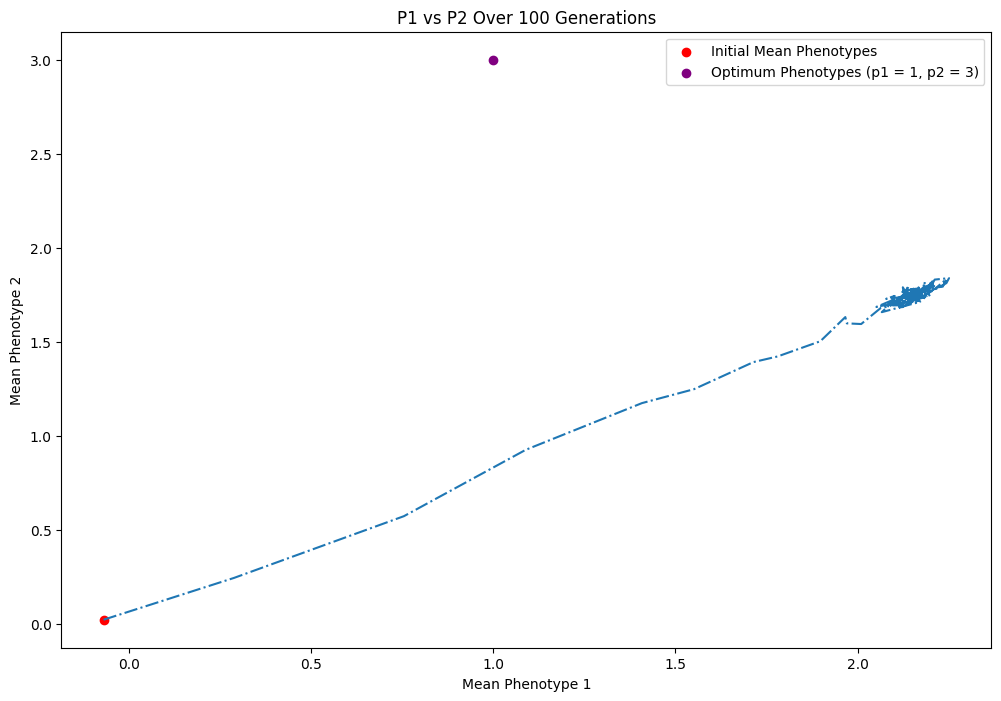

In [18]:
h2_1 = 0.8
h2_2 = 0.5
rg = 1
re = 0

simulated_generations = gen1.next_gen_simulator(100, gaussian_w_from_p, h2_1, h2_2, beta_1, beta_2, rg, re)
exp_p1, exp_p2 = gen1.next_gen_expected_simulator(100, h2_1, h2_2, beta_1, beta_2)

p1_mean = [np.mean(simulated_generations[i].p1) for i in range(100)]
p2_mean = [np.mean(simulated_generations[i].p2) for i in range(100)]

plt.figure(figsize = (12, 8))
plt.plot(p1_mean, p2_mean, linestyle = 'dashdot')
plt.xlabel('Mean Phenotype 1')
plt.ylabel('Mean Phenotype 2')
plt.title('P1 vs P2 Over 100 Generations')
plt.scatter(p1_mean[0], p2_mean[0], c = 'red', label = 'Initial Mean Phenotypes')
plt.scatter(1, 3, c = 'purple', label = 'Optimum Phenotypes (p1 = 1, p2 = 3)')
plt.legend()

<built-in function len>


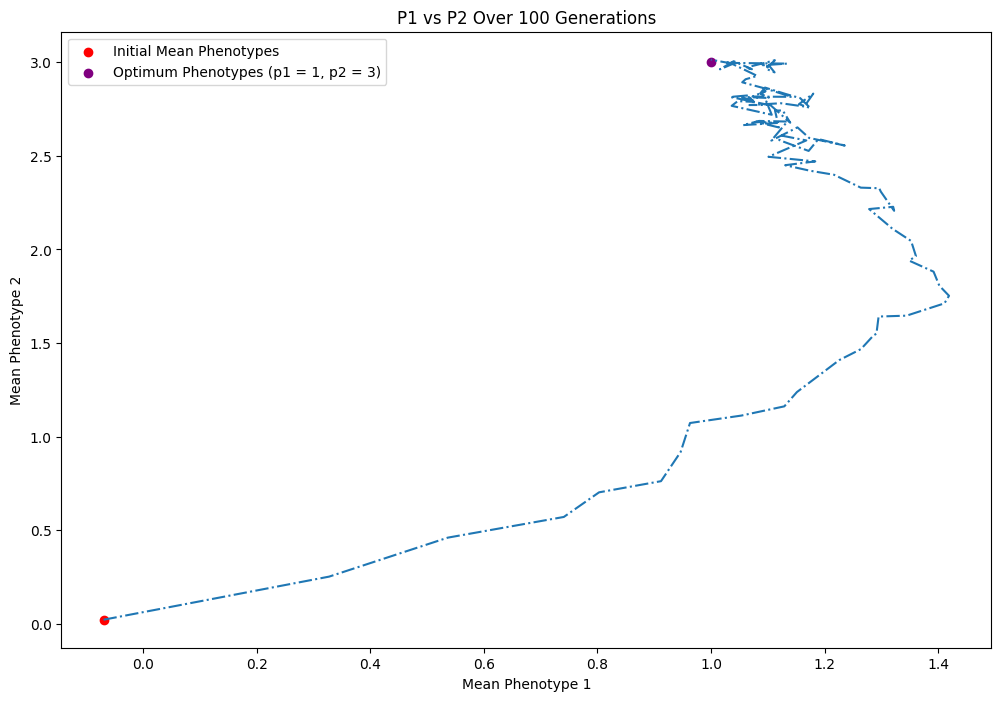

In [19]:
h2_1 = 0.8
h2_2 = 0.5
rg = -0.5
re = 0

simulated_generations = gen1.next_gen_simulator(100, gaussian_w_from_p, h2_1, h2_2, beta_1, beta_2, rg, re)
exp_p1, exp_p2 = gen1.next_gen_expected_simulator(100, h2_1, h2_2, beta_1, beta_2)

p1_mean = [np.mean(simulated_generations[i].p1) for i in range(100)]
p2_mean = [np.mean(simulated_generations[i].p2) for i in range(100)]

plt.figure(figsize = (12, 8))
plt.plot(p1_mean, p2_mean, linestyle = 'dashdot')
plt.xlabel('Mean Phenotype 1')
plt.ylabel('Mean Phenotype 2')
plt.title('P1 vs P2 Over 100 Generations')
plt.scatter(p1_mean[0], p2_mean[0], c = 'red', label = 'Initial Mean Phenotypes')
plt.scatter(1, 3, c = 'purple', label = 'Optimum Phenotypes (p1 = 1, p2 = 3)')
plt.legend()

<built-in function len>


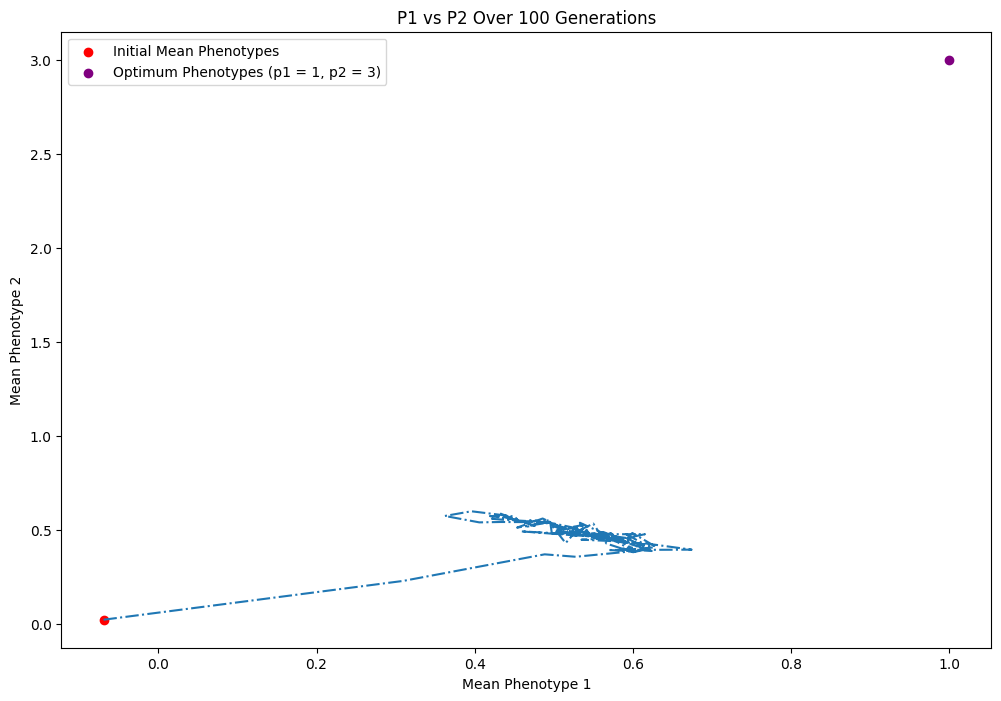

In [20]:
h2_1 = 0.8
h2_2 = 0.5
rg = -1
re = 0

simulated_generations = gen1.next_gen_simulator(100, gaussian_w_from_p, h2_1, h2_2, beta_1, beta_2, rg, re)
exp_p1, exp_p2 = gen1.next_gen_expected_simulator(100, h2_1, h2_2, beta_1, beta_2)

p1_mean = [np.mean(simulated_generations[i].p1) for i in range(100)]
p2_mean = [np.mean(simulated_generations[i].p2) for i in range(100)]

plt.figure(figsize = (12, 8))
plt.plot(p1_mean, p2_mean, linestyle = 'dashdot')
plt.xlabel('Mean Phenotype 1')
plt.ylabel('Mean Phenotype 2')
plt.title('P1 vs P2 Over 100 Generations')
plt.scatter(p1_mean[0], p2_mean[0], c = 'red', label = 'Initial Mean Phenotypes')
plt.scatter(1, 3, c = 'purple', label = 'Optimum Phenotypes (p1 = 1, p2 = 3)')
plt.legend()

##### When the genetic correlation is 0, P2 moves steadily toward the ideal phenotype, while P1 overshoots the ideal phenotype and then makes it way back. It does converge to the ideal phenotypes within 100 generations. When the genetic correlation is positive, the trajectory of P1 and P2 follows the same path, but doesn't make it all the way to the ideal phenotypes. It converges at a different value. A higher genetic correlation, up to a perfect correlation, causes the trajectory to get cut off earlier (converging at a value farther away from the ideal P1 and P2). A negative genetic correlation of -0.5 allows the phenotypes to both reach their ideal values quickly (faster than with uncorrelated traits). This is the fastest convergence I observed in this sample. A negative genetic correlation of -1 cuts off the trajectory very early, far away from the ideal values. 

<built-in function len>


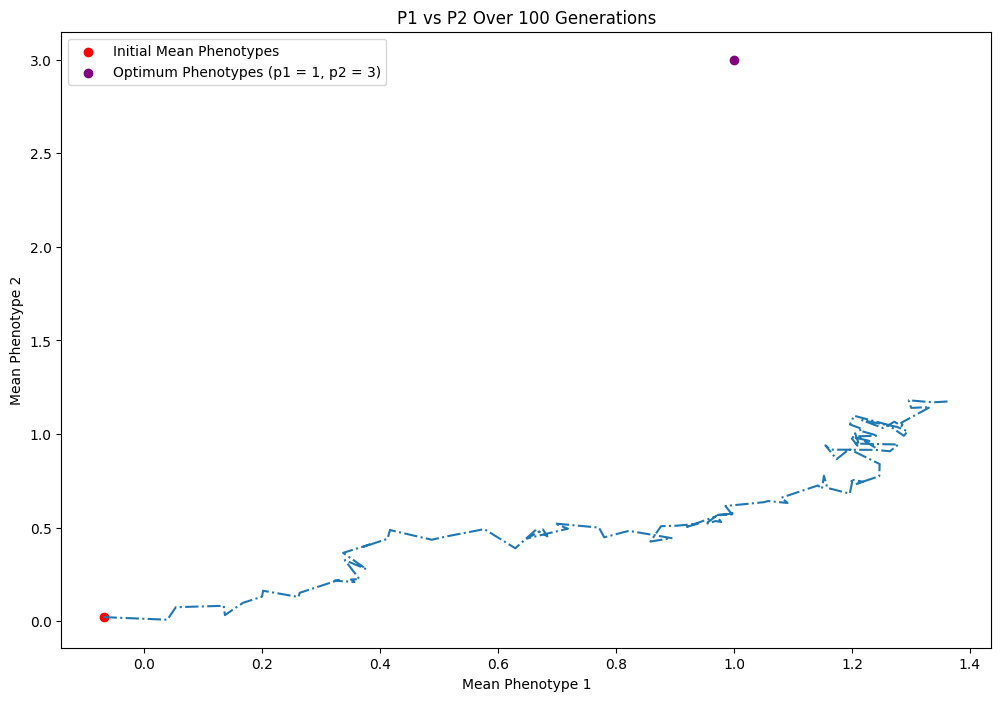

In [24]:
def gaussian_w_from_p_diffcov(p1, p2):
    
    # setting the ideal phenotypes to be p1 = 1, p2 = 3
    mu = np.array([1, 3])
    cov = np.array([[100, -70], [-70, 100]])
    
    p1 = np.array(p1)
    p2 = np.array(p2)
    points = np.vstack((p1, p2)).T
    inv_cov = np.linalg.inv(cov)

    # mahalanobis comes from scipy
    w = np.array([
        np.exp(-0.5 * mahalanobis(point, mu, inv_cov)**2)
        for point in points
    ])
    return w

h2_1 = 0.8
h2_2 = 0.5
rg = -0.5
re = 0

simulated_generations = gen1.next_gen_simulator(100, gaussian_w_from_p_diffcov, h2_1, h2_2, beta_1, beta_2, rg, re)
exp_p1, exp_p2 = gen1.next_gen_expected_simulator(100, h2_1, h2_2, beta_1, beta_2)

p1_mean = [np.mean(simulated_generations[i].p1) for i in range(100)]
p2_mean = [np.mean(simulated_generations[i].p2) for i in range(100)]

plt.figure(figsize = (12, 8))
plt.plot(p1_mean, p2_mean, linestyle = 'dashdot')
plt.xlabel('Mean Phenotype 1')
plt.ylabel('Mean Phenotype 2')
plt.title('P1 vs P2 Over 100 Generations')
plt.scatter(p1_mean[0], p2_mean[0], c = 'red', label = 'Initial Mean Phenotypes')
plt.scatter(1, 3, c = 'purple', label = 'Optimum Phenotypes (p1 = 1, p2 = 3)')
plt.legend()

<built-in function len>


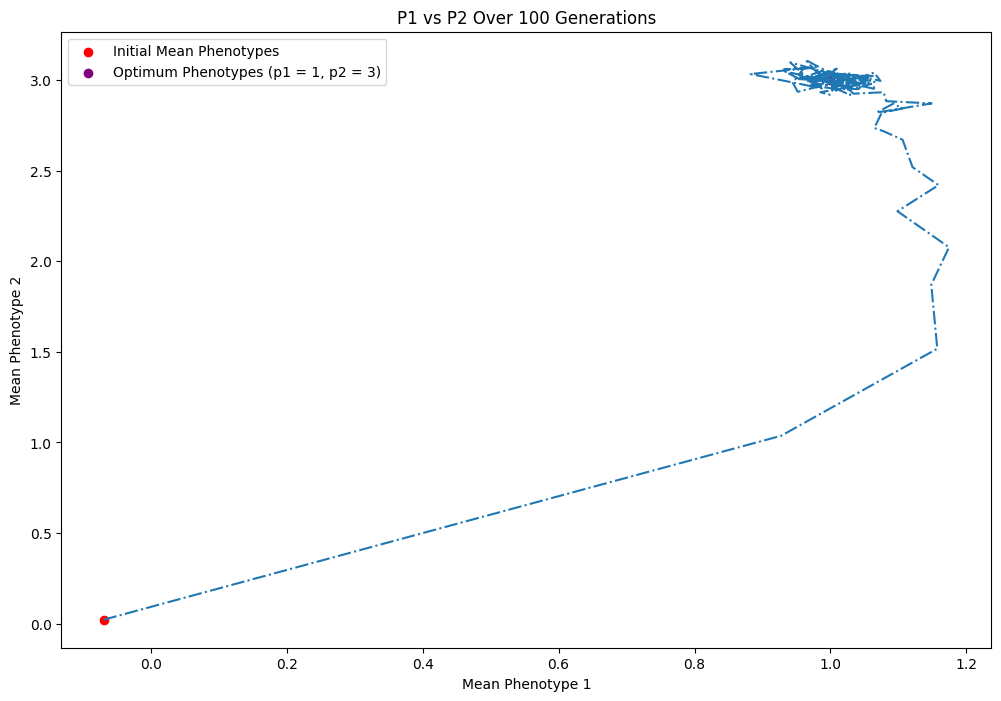

In [25]:
def gaussian_w_from_p_diffcov(p1, p2):
    
    # setting the ideal phenotypes to be p1 = 1, p2 = 3
    mu = np.array([1, 3])
    cov = np.array([[1.00, -.70], [-.70, 1.00]])
    
    p1 = np.array(p1)
    p2 = np.array(p2)
    points = np.vstack((p1, p2)).T
    inv_cov = np.linalg.inv(cov)

    # mahalanobis comes from scipy
    w = np.array([
        np.exp(-0.5 * mahalanobis(point, mu, inv_cov)**2)
        for point in points
    ])
    return w

h2_1 = 0.8
h2_2 = 0.5
rg = -0.5
re = 0

simulated_generations = gen1.next_gen_simulator(100, gaussian_w_from_p_diffcov, h2_1, h2_2, beta_1, beta_2, rg, re)
exp_p1, exp_p2 = gen1.next_gen_expected_simulator(100, h2_1, h2_2, beta_1, beta_2)

p1_mean = [np.mean(simulated_generations[i].p1) for i in range(100)]
p2_mean = [np.mean(simulated_generations[i].p2) for i in range(100)]

plt.figure(figsize = (12, 8))
plt.plot(p1_mean, p2_mean, linestyle = 'dashdot')
plt.xlabel('Mean Phenotype 1')
plt.ylabel('Mean Phenotype 2')
plt.title('P1 vs P2 Over 100 Generations')
plt.scatter(p1_mean[0], p2_mean[0], c = 'red', label = 'Initial Mean Phenotypes')
plt.scatter(1, 3, c = 'purple', label = 'Optimum Phenotypes (p1 = 1, p2 = 3)')
plt.legend()

<built-in function len>


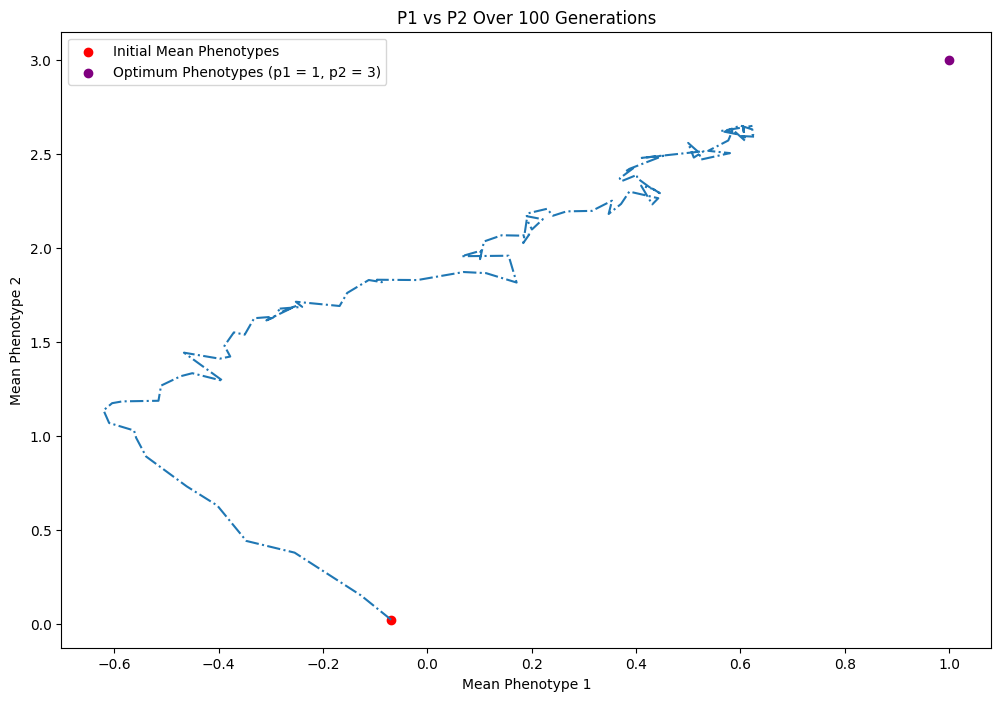

In [28]:
def gaussian_w_from_p_diffcov(p1, p2):
    
    # setting the ideal phenotypes to be p1 = 1, p2 = 3
    mu = np.array([1, 3])
    cov = np.array([[10, 7], [7, 10]])
    
    p1 = np.array(p1)
    p2 = np.array(p2)
    points = np.vstack((p1, p2)).T
    inv_cov = np.linalg.inv(cov)

    # mahalanobis comes from scipy
    w = np.array([
        np.exp(-0.5 * mahalanobis(point, mu, inv_cov)**2)
        for point in points
    ])
    return w

h2_1 = 0.8
h2_2 = 0.5
rg = -0.5
re = 0

simulated_generations = gen1.next_gen_simulator(100, gaussian_w_from_p_diffcov, h2_1, h2_2, beta_1, beta_2, rg, re)
exp_p1, exp_p2 = gen1.next_gen_expected_simulator(100, h2_1, h2_2, beta_1, beta_2)

p1_mean = [np.mean(simulated_generations[i].p1) for i in range(100)]
p2_mean = [np.mean(simulated_generations[i].p2) for i in range(100)]

plt.figure(figsize = (12, 8))
plt.plot(p1_mean, p2_mean, linestyle = 'dashdot')
plt.xlabel('Mean Phenotype 1')
plt.ylabel('Mean Phenotype 2')
plt.title('P1 vs P2 Over 100 Generations')
plt.scatter(p1_mean[0], p2_mean[0], c = 'red', label = 'Initial Mean Phenotypes')
plt.scatter(1, 3, c = 'purple', label = 'Optimum Phenotypes (p1 = 1, p2 = 3)')
plt.legend()

##### A smaller covariance matrix (smaller values) makes the phenotype move to the ideal much faster, while a larger covariance matrix makes the phenotype move slower to the ideal. This makes sense, as the path to the ideal is much more linear with the small covariance, while a larger covariance means there is more variability in the path to the ideal. Changing the value of the covariance from negative to positive switches the direction of the trajectory - when the covariance is positive, P1 moves toward the ideal, overshoots it, and then moves toward it again. When the covariance is negtaive, P1 moves away from the ideal first and then toward it. 